In [1]:
import torch
import os
from torch import nn
from gan.settings import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Preprocess
### prepare midi dataset if needed.

In [2]:
from gan.preprocess import prepare_dataset, preprocess_dataset
songs_dir_path = os.path.join('gan','toy_set_songs')
out_merged_dir_path = os.path.join('gan', 'toy_set_merged')
data = prepare_dataset(songs_dir_path, out_merged_dir_path)

Loading songs from "gan\toy_set_songs"...
.........Loaded 9 songs.
filtering songs


100%|██████████| 9/9 [00:00<00:00, 2999.26it/s]


9/9 songs are 4/4
merging


100%|██████████| 9/9 [00:01<00:00,  7.74it/s]

total 9 songs were saved to gan\toy_set_merged


### create npy if needed

In [3]:
npy_out_name = os.path.join('toy_data_npy.npy')
out_merged_dir_path = os.path.join('gan', 'toy_set_merged')
out_npy_file_path = os.path.join('gan', 'toy_data_npy.npy')
dataset = preprocess_dataset(out_merged_dir_path, out_npy_file_path)

Error occured in readme.txt
MThd not found. Probably not a MIDI file


100%|██████████| 9/9 [00:00<00:00, 562.37it/s]

Dataset shape : (79, 4, 4, 16, 84)
Dataset saved to gan\toy_data_npy.npy


## Dataset Loader

In [4]:
from gan.dataset import Dataset
from torch.utils.data import DataLoader
dataset = Dataset(file=out_npy_file_path, max_num_files=70)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

Dataset shape : (70, 4, 4, 16, 84)


## Define Models
### Generator


In [5]:
from gan.gan import MuseGenerator
from gan.settings import N_TRACKS
generator = MuseGenerator()
cords = torch.rand(10, 32)
style = torch.rand(10, 32)
melody = torch.rand(10, N_TRACKS, 32)
groove = torch.rand(10, N_TRACKS, 32)

generator(cords, style, melody, groove).shape

torch.Size([10, 4, 4, 16, 84])

In [6]:
generator = MuseGenerator(z_dim=32, hid_channels=1024, hid_features=1024, out_channels=1).to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

### Critic

In [7]:
from gan.gan import MuseCritic
from gan.settings import N_TRACKS, N_BARS, N_STEPS_PER_BAR
critic = MuseCritic()
a = torch.rand(10, N_TRACKS, N_BARS, N_STEPS_PER_BAR, 84)
critic(a).shape

torch.Size([10, 1])

In [8]:
critic = MuseCritic(hid_channels=128,
                    hid_features=1024,
                    out_features=1).to(device)
c_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001, betas=(0.5, 0.9))

In [9]:
from gan.utils import initialize_weights

generator = generator.apply(initialize_weights)
critic = critic.apply(initialize_weights)

# Training

In [10]:
from gan.train import Trainer
out_path = os.path.join('gan', 'my_trained_models', 'modelA')
trainer = Trainer(generator, critic, g_optimizer, c_optimizer, out_path, device)
num_epochs = 10
trainer.train(dataloader, epochs=num_epochs, device=device)
losses = trainer.data.copy()

gan\my_trained_models\modelA


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0/10 | Generator loss: 669.808 | Critic loss: -444.136 (fake: -284.929, real: -159.207, penalty: 230.957)


# Save models and loss data

In [11]:
import pandas as pd
import os
generator = generator.eval().cpu()
#critic = critic.eval().cpu()
out_path = os.path.join('gan', 'my_trained_models', 'modelA')
if not os.path.exists(out_path):
    os.makedirs(out_path)
torch.save(generator, os.path.join(out_path, f'generator_e{num_epochs}_s{len(dataset)}.pt'))
torch.save(critic, os.path.join(out_path, f'critic_e{num_epochs}_s{len(dataset)}.pt'))
losses = trainer.data.copy()
df = pd.DataFrame.from_dict(losses)
df.to_csv(os.path.join(out_path, 'results.csv'), index=False)

## Plot Data

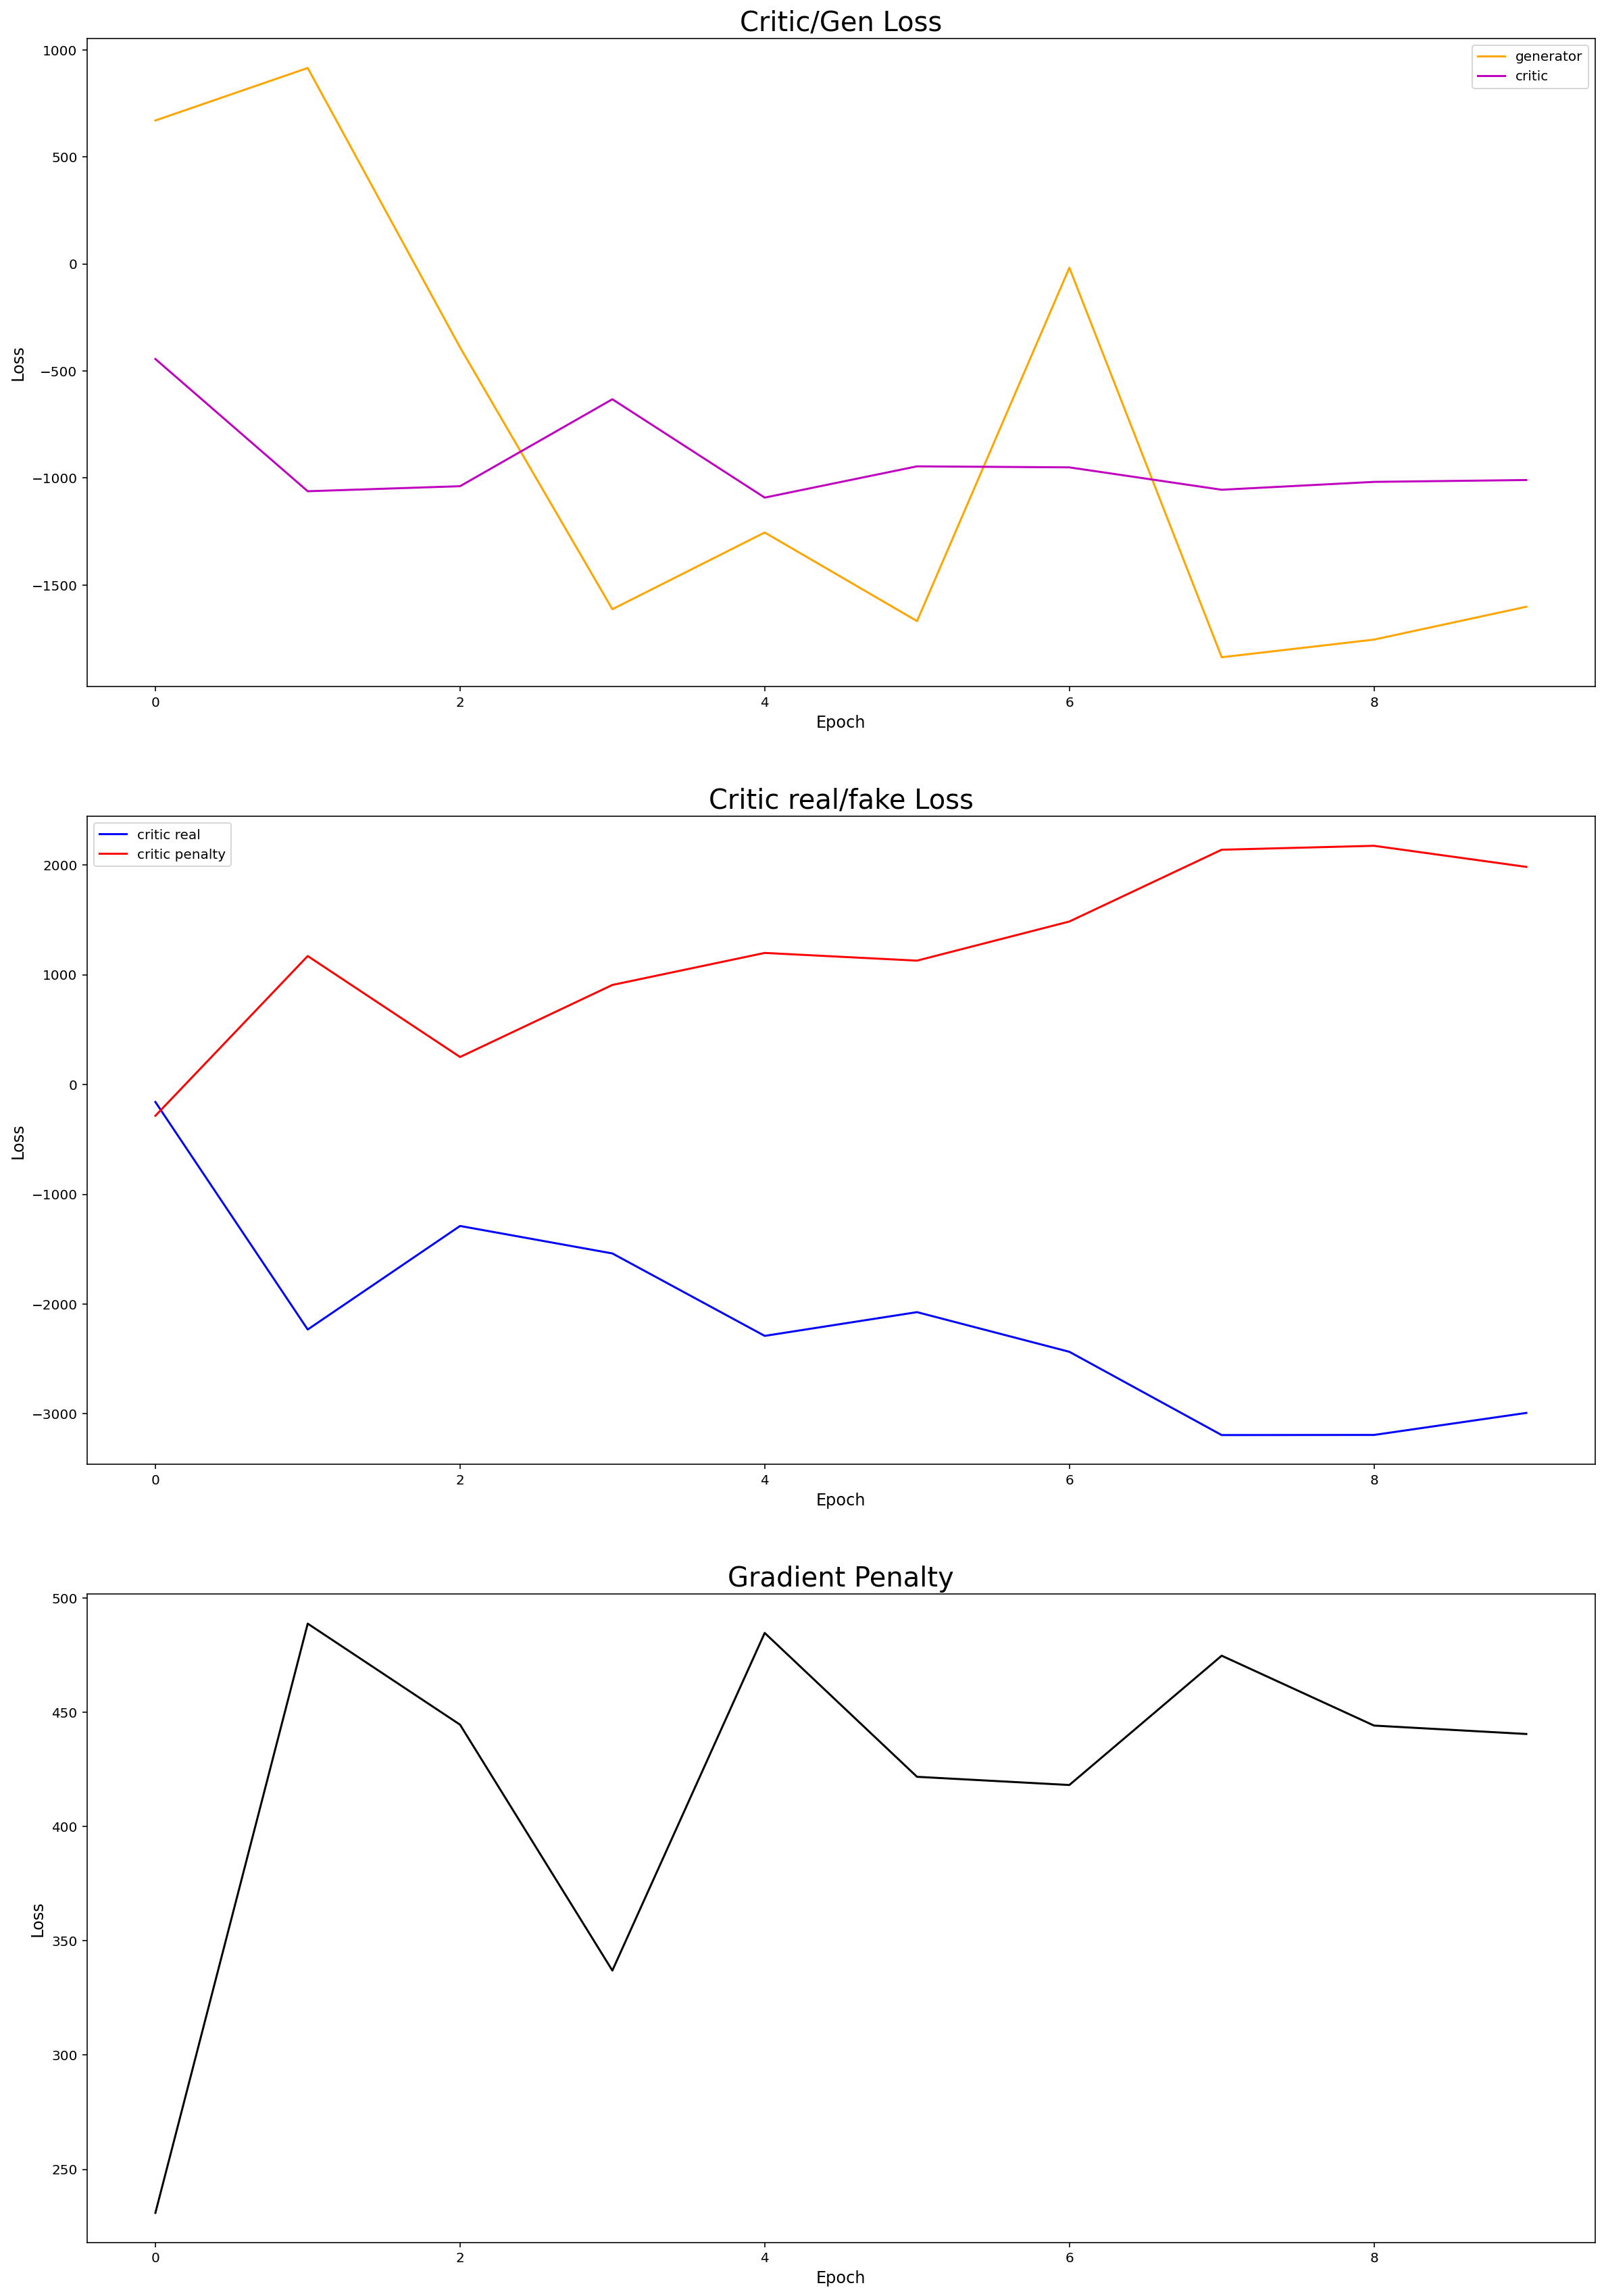

In [12]:
import pandas as pd
from gan.utils import plot_losses
df = pd.read_csv(os.path.join(out_path, 'results.csv'))
losses = pd.DataFrame.from_dict(df)
plot_losses(losses)

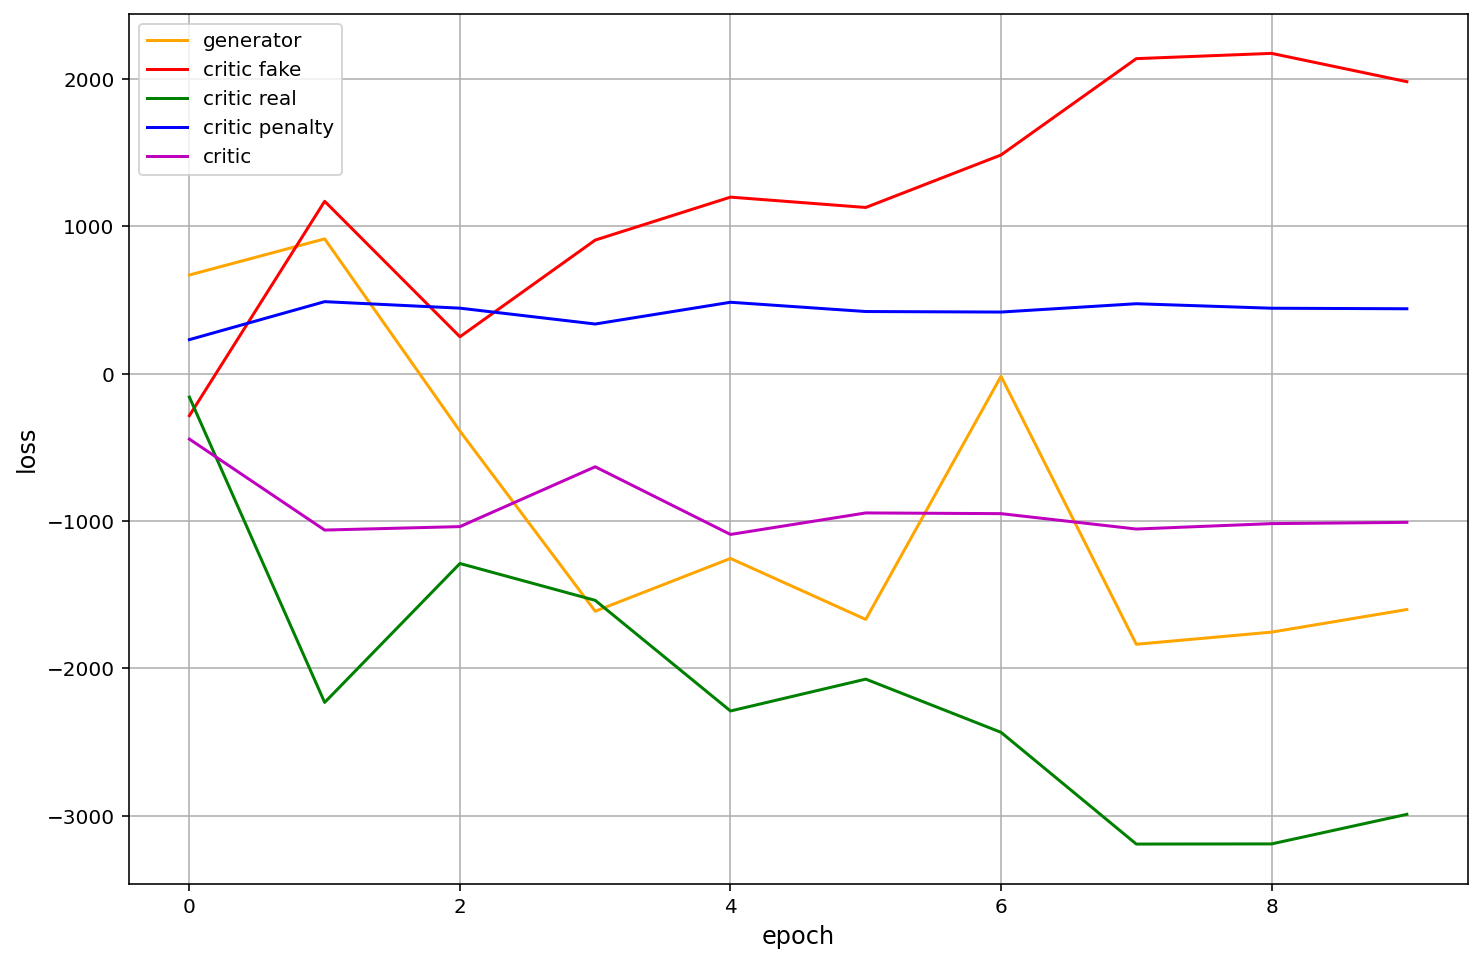

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(losses['gloss'], 'orange', label='generator')
plt.plot(losses['cfloss'], 'r', label='critic fake')
plt.plot(losses['crloss'], 'g', label='critic real')
plt.plot(losses['cploss'], 'b', label='critic penalty')
plt.plot(losses['closs'], 'm', label='critic')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()
plt.legend()
plt.show()
plt.savefig('losses.png')

### Generate Samples

In [14]:
from gan.utils import parseToMidi
import torch
import os

num_samples = 1
num_tracks = 4
z_dim = 32

model_path = os.path.join('gan', 'my_trained_models', 'modelA')
gen_path =  os.path.join(model_path, 'generator_e20_s79.pt')

generator = torch.load(gen_path)

chords = torch.randn(num_samples, z_dim)
style = torch.randn(num_samples, z_dim)
melody = torch.randn(num_samples, num_tracks, z_dim)
groove = torch.randn(num_samples, num_tracks, z_dim)

sample = generator(chords, style, melody, groove).detach()

parseToMidi(sample, midi_out_path=model_path, name="My Track")